In [1]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import numpy as np
from PIL import Image

def train_validation_test_split(X, y, train_size, val_size, random_state):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=val_size / (1 - train_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

def load_one_folder(folder_path, label, image_size):
    images = []
    for filename in os.listdir(folder_path):
        with Image.open(os.path.join(folder_path, filename)) as img:
            image = img.convert("RGB").resize(image_size)
            images.append(np.array(image, dtype=np.uint8))
    return images, [label] * len(images)

def load_all_folders(folder_path, label_names, image_size):
    X = []
    y = []
    for label in range(len(label_names)):
        X_temp, y_temp = load_one_folder(os.path.join(folder_path, label_names[label]), label, image_size)
        X += X_temp
        y += y_temp
    return np.array(X), np.array(y)


def make_subsets():
    folder_path = "../Data/garbage-dataset/"
    label_names = [filename for filename in os.listdir(folder_path)]

    X, y = load_all_folders(folder_path, label_names, (400, 400))
    X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X, y, train_size=0.6, val_size=0.2, random_state=42)
    return X_train, y_train, X_test, y_test, label_names

In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet201

def define_base_model():
    """
    This function defines the base model i.e DenseNet201
    """

    conv_base = DenseNet201(
        weights="imagenet",
        include_top=False,
    )

    # This empties the list of trainable weights i.e. freezing weights of convolutional base  
    # Convolutional layers in pre-trained models have learnt features e.g. edges, shapes etc. 
    # Therefore we extract these features from the convolutional base, to be used in tailored model 
    conv_base.trainable = False

    # Printing model summary 
    # conv_base.summary()

    return conv_base

def build_model(label_number):
    """
    This function builds a convolutional neural network model.

    """

    # Data augmentation 
    data_augmentation = keras.Sequential([
        layers.RandomRotation(0.111),     # ~40 degrees (0.111 * 360 ≈ 40°)
        layers.RandomZoom(0.2),           # zoom up to 20%
        layers.RandomFlip("horizontal"),  # horizontal flip
        layers.RandomWidth(0.2),          # width shift up to 20%
        layers.RandomHeight(0.2),         # height shift up to 20%
    ])

    inputs = keras.Input(shape=(400, 400, 3))  
    x = data_augmentation(inputs)

    # Passing through the convolutional base
    conv_base = define_base_model()
    x = conv_base(x)

    # Reducing the entire feature map into single vector; reduces overfitting and has fewer parameter than Flatten
    x = layers.GlobalAveragePooling2D()(x)
    
    # Defining Dense and Dropout layers
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Defining the outputs 
    outputs = layers.Dense(label_number, activation = "softmax")(x) # defined for 3 output classes

    model = keras.Model(inputs, outputs)

    # Compiling the model
    model.compile(optimizer="rmsprop", #==================================================== can adjust to adam or sgd
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

def train_model(model, train_X, train_y):
    history = model.fit(
        train_X,
        train_y,
        epochs=20, 
        validation_split=0.2,
    )
    
    return history

def test_model(model, test_X, test_y):  
    # test_model = keras.models.load_model(best_model_file)
    test_loss, test_acc = model.evaluate(test_X, test_y)
    print(f"\nTest accuracy: {test_acc:.3f}")
    
    return test_acc, test_loss


In [3]:
import time
import pandas as pd
import keras

# train_dataset, validation_dataset, test_dataset, label_names = make_subsets()
X_train, y_train, X_test, y_test, label_names = make_subsets()

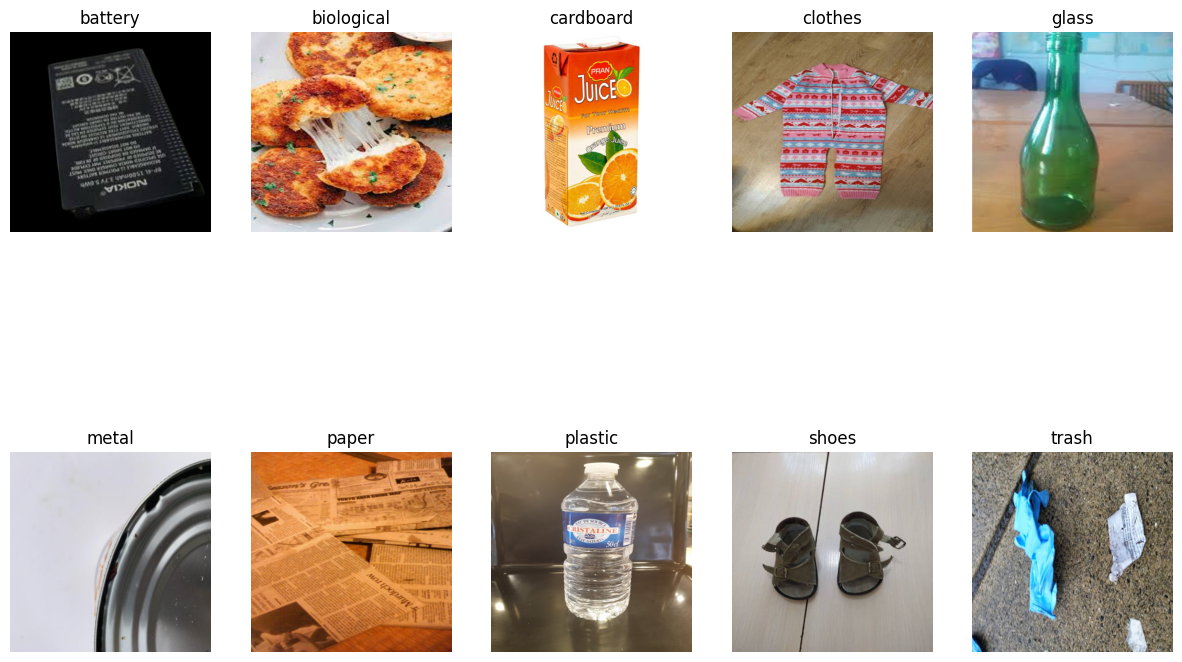

In [40]:

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15, 10))

first_occurrence = {}
for index, (image, label) in enumerate(zip(X_train, y_train)):
    if label_names[label] not in first_occurrence:
        first_occurrence[label_names[label]] = image
    if len(first_occurrence) == len(label_names):
        break

for index, label_name in enumerate(label_names):
  axis = fig.add_subplot(2, 5, index + 1)
  axis.axis('off')
  axis.set_title(label_name)
  axis.imshow(first_occurrence[label_name])

In [4]:
X_train = np.array(X_train[:100])
y_train = np.array(y_train[:100])

In [5]:
model = build_model(len(label_names))

history = train_model(model, X_train, y_train)

model.save("best_model.keras")
history_df = pd.DataFrame(history.history)
history_df.to_csv("training_history.csv", index=False)



Epoch 1/20
3/3 [==============================] - 22s 6s/step - loss: 13.1620 - accuracy: 0.0625 - val_loss: 16.6715 - val_accuracy: 0.1500
Epoch 2/20
3/3 [==============================] - 14s 5s/step - loss: 9.0338 - accuracy: 0.1250 - val_loss: 6.6357 - val_accuracy: 0.1500
Epoch 3/20
3/3 [==============================] - 17s 6s/step - loss: 5.0713 - accuracy: 0.2375 - val_loss: 4.4465 - val_accuracy: 0.2000
Epoch 4/20
3/3 [==============================] - 18s 6s/step - loss: 4.0798 - accuracy: 0.2875 - val_loss: 4.3785 - val_accuracy: 0.2500
Epoch 5/20
3/3 [==============================] - 15s 5s/step - loss: 3.0055 - accuracy: 0.2750 - val_loss: 3.7704 - val_accuracy: 0.3000
Epoch 6/20
3/3 [==============================] - 17s 6s/step - loss: 2.2651 - accuracy: 0.3750 - val_loss: 4.8437 - val_accuracy: 0.2000
Epoch 7/20
3/3 [==============================] - 16s 5s/step - loss: 2.5768 - accuracy: 0.4250 - val_loss: 2.8597 - val_accuracy: 0.5000
Epoch 8/20
3/3 [================

In [8]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_history(history):
    """
    This function plots the training and validation accuracy and loss.
    """

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], "bo", label="Training accuracy")
    plt.plot(history['val_accuracy'], "b", label="Validation accuracy")
    plt.title("Training and validation accuracy", fontsize = 16)
    plt.xlabel("Epochs", fontsize = 12)
    plt.ylabel("Accuracy", fontsize = 12)
    plt.xlim([0, len(history)])  # Valid x-range
    plt.xticks(range(len(history)))  # Set ticks for all epochs
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], "bo", label="Training loss")
    plt.plot(history['val_loss'], "b", label="Validation loss")
    plt.title("Training and validation loss", fontsize = 16)
    plt.xlabel("Epochs", fontsize = 12)
    plt.ylabel("Loss", fontsize = 12)
    plt.xlim([0, len(history)])  # Valid x-range
    plt.xticks(range(len(history)))  # Optional: tick at every epoch
    plt.legend()

    plt.show()

def calculate_metrics(model, X_test, y_test, label_names):
    """
    This function calculates the evaluation metrics - accuracy, precision, recall, F1 score.
    """


    # Predicting class probabilities
    y_pred_probs = model.predict(X_test)

    # Converting probabilities to class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)  

    # Computing evaluation metrics per class
    report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)

    # Converting to a DataFrame for better readability
    df_report = pd.DataFrame(report).transpose()

    # Display the table
    print("\n==================== Evaluation Metrics Report ====================")
    print(df_report)
    print("\n")

    # Saving to CSV file
    df_report.to_csv("evaluation_metrics.csv")

    return y_pred


def plot_confusion_matrix(y_true, y_pred, label_names):
    """
    This function plots the confusion matrix.
    """

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True, xticklabels= label_names, yticklabels= label_names)
    plt.xlabel("Predicted Labels", fontsize = 12)
    plt.ylabel("True Labels", fontsize = 12)
    plt.title("Confusion Matrix of DenseNet201 Classifier", fontsize = 14)
    plt.show()



4/4 [==============================] - 15s 3s/step - loss: 1.4333 - accuracy: 0.6300

Test accuracy: 0.630
4/4 [==============================] - 14s 3s/step

==================== Evaluation Metrics Report ====================
              precision    recall  f1-score  support
battery        0.750000  0.500000  0.600000     6.00
biological     1.000000  0.250000  0.400000     4.00
cardboard      0.500000  0.500000  0.500000    10.00
clothes        0.814815  0.846154  0.830189    26.00
glass          0.888889  0.533333  0.666667    15.00
metal          1.000000  1.000000  1.000000     3.00
paper          0.857143  0.545455  0.666667    11.00
plastic        1.000000  0.400000  0.571429    10.00
shoes          0.314286  1.000000  0.478261    11.00
trash          0.000000  0.000000  0.000000     4.00
accuracy       0.630000  0.630000  0.630000     0.63
macro avg      0.712513  0.557494  0.571321   100.00
weighted avg   0.739042  0.630000  0.630934   100.00




c:\Users\Charlie\.virtualenvs\Model-mJPrqH2R\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Charlie\.virtualenvs\Model-mJPrqH2R\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Charlie\.virtualenvs\Model-mJPrqH2R\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

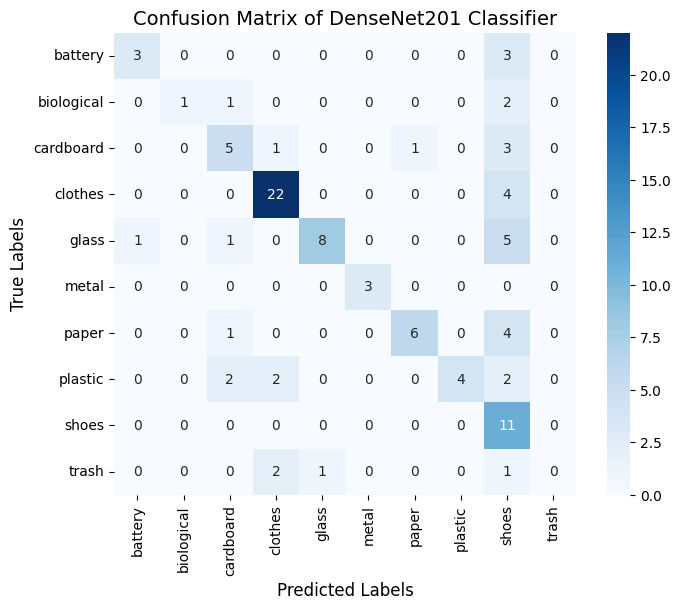

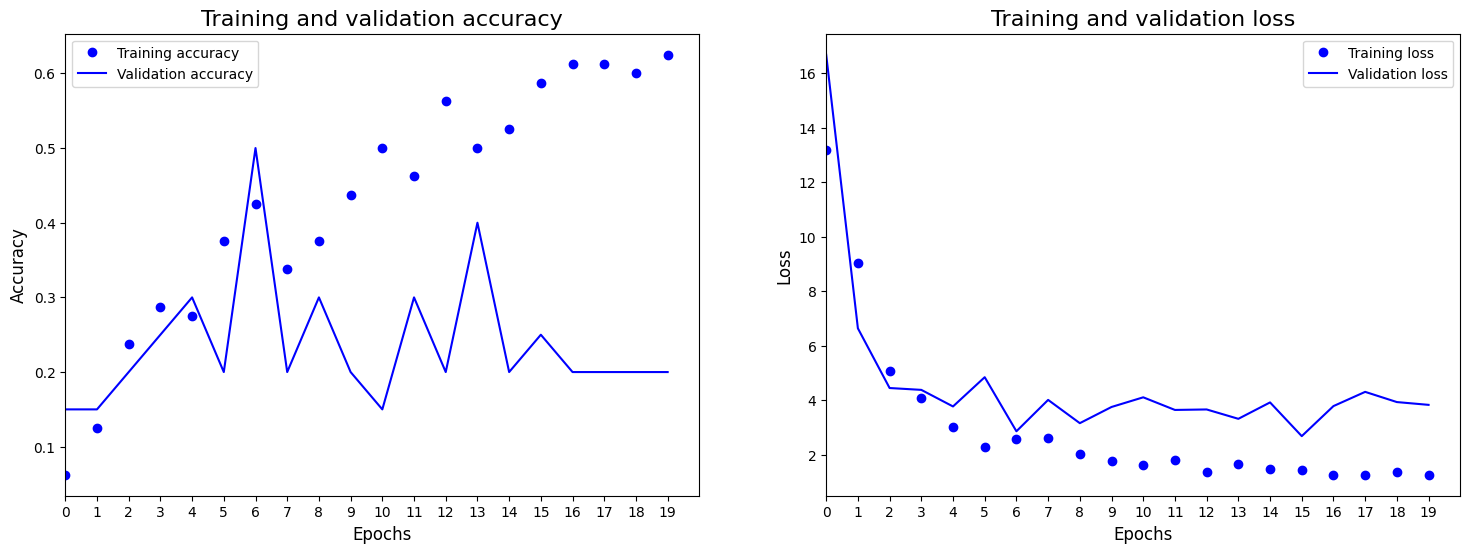

In [ ]:

import pickle

# Load the model from the .pkl file
with open("best_model.pkl", "rb") as file:
    best_model = pickle.load(file)

test_acc, test_loss = test_model(model, X_train, y_train)


# Evaluating metrics and plotting confusion matrix
y_pred = calculate_metrics(model, X_train, y_train, label_names)
plot_confusion_matrix(y_train, y_pred, label_names)

# Plotting history 
plot_history(history_df)